____
# Attentive CONV-LSTM

In [15]:
import pandas as pd

tweets_df = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\code_archive_diss\test_csvs\lsa_volume.csv')
tweets_df = tweets_df[tweets_df['ticker_symbol']=='AAPL']
tweets_df.rename(columns={'market_date': 'date'}, inplace=True)
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import stockstats
from pandas.tseries.holiday import USFederalHolidayCalendar
from fredapi import Fred
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from joblib import Parallel, delayed
import seaborn as sns


from models import att_lstm_cnn as attention
sns.set(style="whitegrid")


In [27]:

def fetch_stock_data(ticker, start_date, end_date):
    # return pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\models\aapl_stocks_2015_2019.csv')
    return yf.download(ticker, start=start_date, end=end_date)

def add_technical_indicators(data):
    """ 
    Add technical indicators and macroeconomic data to the DataFrame. 
    """

    stock = stockstats.StockDataFrame.retype(data)
    
    # stockstats indicators - no need to shift
    data['sma_20'] = stock['close_20_sma']
    data['ema_20'] = stock['close_20_ema']
    data['rsi_14'] = stock['rsi_14']
    data['macd'] = stock['macd'] - stock['macds']
    data['boll'] = stock['boll']
    data['boll_ub'] = stock['boll_ub']
    data['boll_lb'] = stock['boll_lb']
    data['cci_14'] = stock['cci_14']
    data['atr_14'] = stock['atr_14']

    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    data['is_holiday'] = data.index.isin(holidays).astype(int)

    # Custom calculated indicators - need shifting
    data['daily_return'] = data['close'].pct_change().shift(1)
    data['volatility'] = data['daily_return'].rolling(window=20).std().shift(1) * np.sqrt(252)
    data['obv'] = (np.sign(data['close'].diff()) * data['volume']).cumsum().shift(1)
    data['roc'] = data['close'].pct_change(periods=12).shift(1)

    # External data - shift VIX and USDX
    vix_data = yf.download('^VIX', start=data.index.min(), end=data.index.max())
    usdx_data = yf.download('DX-Y.NYB', start=data.index.min(), end=data.index.max())
    data['vix'] = vix_data['Close'].reindex(data.index, method='ffill').shift(1)
    data['usdx'] = usdx_data['Close'].reindex(data.index, method='ffill').shift(1)

    # FRED API data - assuming correct alignment, no shift needed
    fred = Fred(api_key="9bdd17c1e9c9a71b4fabb8dc5636314d")
    data['gdp_growth'] = fred.get_series('A191RL1Q225SBEA').reindex(data.index, method='ffill')
    data['interest_rate'] = fred.get_series('DFF').reindex(data.index, method='ffill')
    data['inflation_rate'] = fred.get_series('CPIAUCSL').pct_change(12).reindex(data.index, method='ffill')
    data['effr'] = fred.get_series('EFFR').reindex(data.index, method='ffill')
    data['unemployment_rate'] = fred.get_series('UNRATE').reindex(data.index, method='ffill')
    data['consumer_sentiment'] = fred.get_series('UMCSENT').reindex(data.index, method='ffill')

    # Additional macroeconomic data
    # data['oil_price'] = fred.get_series('IR14230').reindex(data.index, method='ffill')
    data['exchange_rate'] = fred.get_series('DEXUSAL').reindex(data.index, method='ffill')
    data['exports'] = fred.get_series('EXPGS').reindex(data.index, method='ffill')
    data['imports'] = fred.get_series('IMPGS').reindex(data.index, method='ffill')
    data['debt'] = fred.get_series('GFDEBTN').reindex(data.index, method='ffill')

    return data

def prepare_sequences(data, features, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:(i + sequence_length)].values)
        y.append(data[target_column].iloc[i + sequence_length])
    return np.array(X), np.array(y)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def plot_results(y_true, y_pred, title, history):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_true)), y_true, label='Actual')
    plt.plot(range(len(y_true)), y_pred, label='Predicted')
    plt.legend()
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

ticker = "AAPL"
start_date = '2015-01-01'
end_date = '2019-12-31'
target_column = 'close'
sequence_length = 30
indicators = ['close']

In [28]:
stock_data = fetch_stock_data(ticker, start_date, end_date)

stock_data = add_technical_indicators(stock_data)

if indicators:
    for indicator in indicators:
        stock_data[f'{indicator}_lag_1'] = stock_data[f'{indicator}'].shift(1)
        stock_data[f'{indicator}_lag_5'] = stock_data[f'{indicator}'].shift(5)
        stock_data[f'{indicator}_lag_10'] = stock_data[f'{indicator}'].shift(10)
# _______________________________________________________________________________________________________
"""
tweets_df['negative_sentiment_times_engagement'] = tweets_df.avg_negative_sentiment * tweets_df.avg_engagement_per_tweet
tweets_df['negative_sentiment_times_reach'] = tweets_df.avg_negative_sentiment * tweets_df.avg_reach_per_tweet
tweets_df['positive_sentiment_times_engagement'] = tweets_df.avg_positive_sentiment * tweets_df.avg_engagement_per_tweet
tweets_df['positive_sentiment_times_reach'] = tweets_df.avg_positive_sentiment * tweets_df.avg_reach_per_tweet
tweets_df['neutral_sentiment_times_engagement'] = tweets_df.avg_neutral_sentiment * tweets_df.avg_engagement_per_tweet
tweets_df['neutral_sentiment_times_reach'] = tweets_df.avg_neutral_sentiment * tweets_df.avg_reach_per_tweet
"""
# _______________________________________________________________________________________________________

# tweet_data = tweets_df[tweets_df['ticker_symbol'] == ticker]
tweet_data = tweets_df
combined_data = pd.merge(stock_data.reset_index(), tweet_data, left_on='Date', right_on='date', how='left')
combined_data.set_index('Date', inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [19]:
# combined_data.to_csv('./csvs/combined.csv', index=False)
# combined_data = pd.read_csv('./csvs/combined.csv')

Selected 23 features out of 39 original features
Selected features: ['open', 'month', 'vix', 'usdx', 'roc', 'cci_14', 'atr_14', 'macd', 'rsi_14', 'unemployment_rate', 'gdp_growth', 'exchange_rate', 'exports', 'tweet_volume', 'avg_sentiment', 'avg_neutral_sentiment', 'avg_positive_sentiment', 'avg_negative_sentiment', 'lsa_topic_0_avg', 'lsa_topic_1_avg', 'total_reach', 'avg_reach_per_tweet', 'high']
Removed features:['high', 'low', 'boll', 'boll_ub', 'boll_lb', 'sma_20', 'ema_20', 'debt', 'imports', 'total_engagement', 'avg_engagement_per_tweet', 'close_lag_1', 'close_lag_5', 'close_lag_10']
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE: 1.2499, RMSE: 1.6409, R2: 0.9529


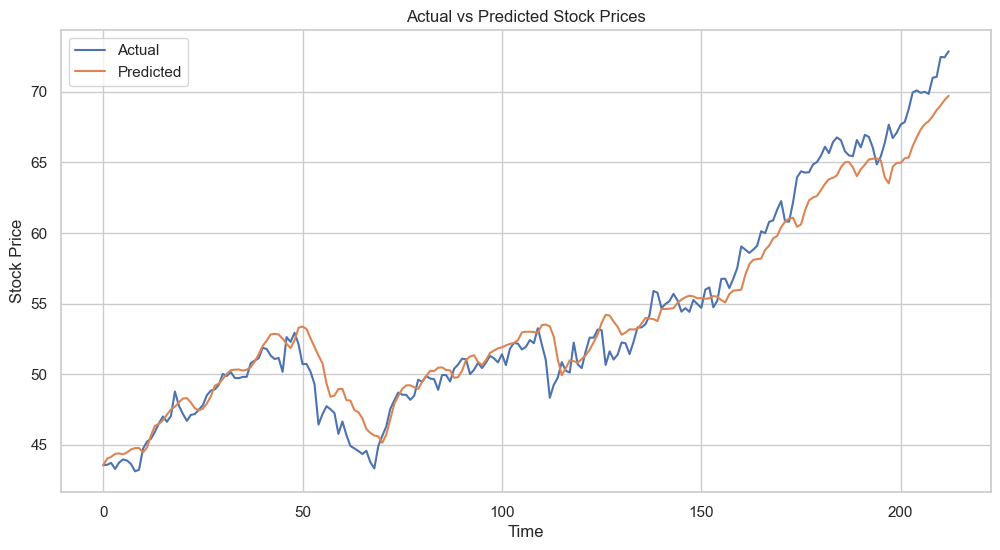

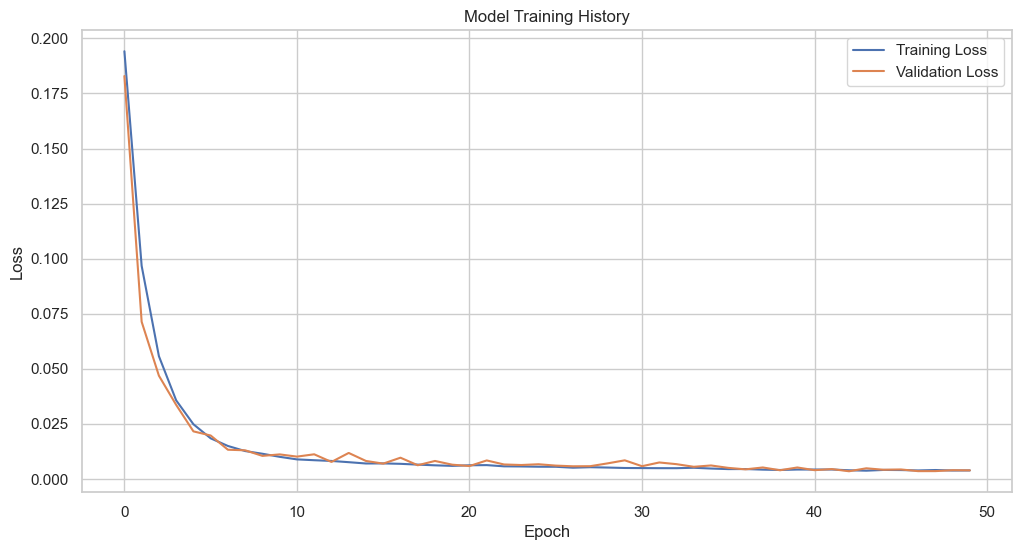

In [31]:
from sklearn.feature_selection import mutual_info_regression


og_features = [            
            # STOCKS
            'open', 'high', 'low',

            # CALENDAR
            'day_of_week', 
            'month', 
            'is_holiday', # -ve 
            
            # INDICATORS
            'vix', 
            'usdx',
            # 'obv', 
            'roc', 
            'boll', 'boll_ub', 'boll_lb', 'cci_14', 
            'atr_14', # -ve 
            # 'volatility', 
            'daily_return',     
            # 'effr', # -ve 
            'sma_20', 'ema_20', 'macd', # MAY INTRODUCE LAG
            'rsi_14',
            # MACROS 
            'unemployment_rate', 
            # 'consumer_sentiment', # -ve
            'gdp_growth', 
            # 'interest_rate', # -ve
            # 'inflation_rate'
            'exchange_rate',
            'debt',
            'exports',
            'imports'
            ]

# tweets_columns = ['tweet_volume', 'avg_sentiment', 'avg_neutral_sentiment',
#     #    'avg_positive_sentiment', #-ve 
#        'avg_negative_sentiment', 'nmf_topic_0_avg',
#     #    'nmf_topic_1_avg', 'nmf_topic_2_avg', #-ve 
#        'nmf_topic_3_avg', 'nmf_topic_4_avg', 'nmf_topic_5_avg', 'nmf_topic_6_avg', 'nmf_topic_7_avg', 
#     #    'nmf_topic_8_avg', #-ve
#        'total_reach',
#        'avg_reach_per_tweet', 'total_engagement', 'avg_engagement_per_tweet']
# og_features += tweets_columns
og_features = og_features+list(tweets_df.columns[2::])

# for i in [0,5,6,7]:
#     og_features.remove(f"nmf_topic_{i}_avg")

if indicators:
    for indicator in indicators:
        og_features.extend([f'{indicator}_lag_1', f'{indicator}_lag_5', f'{indicator}_lag_10'])

# remove = []

# for i in [0,1,2,3]:
    # remove += [f'nmf_topic_{i}_avg']

# og_features = [s for s in og_features if s not in remove]

combined_data = combined_data.dropna()

# ________________________________________________________________________________________________________________________
"""  
Uses mutual information to identify important features.
Among important features, it identifies highly correlated groups.
It keeps all important features that aren't highly correlated with others.
For highly correlated groups, it keeps at least one feature.
"""

def balanced_feature_selection(data, features, target, importance_threshold=0.001, correlation_threshold=0.95):
    # Calculate feature importance
    mi_scores = mutual_info_regression(data[features], data[target])
    mi_scores = pd.Series(mi_scores, index=features)
    important_features = mi_scores[mi_scores > importance_threshold].index.tolist()
    
    # Calculate correlation
    corr_matrix = data[important_features].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]
    
    # Keep at least one from each highly correlated group
    final_features = [f for f in important_features if f not in to_drop]
    final_features.extend(to_drop[:1])  # Add one from the highly correlated group
    
    print(f"Selected {len(final_features)} features out of {len(features)} original features")
    print("Selected features:", final_features)
    print(f"Removed features:{to_drop}")
    
    return final_features

target_column = 'close'
features = balanced_feature_selection(combined_data, og_features, target_column)
features.extend(['close_lag_1', 'close_lag_5', 'close_lag_10', 'debt'])

train_size = int(len(combined_data) * 0.8)
train_data = combined_data.iloc[:train_size]
val_data = combined_data.iloc[train_size:]

scaler = MinMaxScaler()

train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data[features + ['close']]),
                                columns=features + ['close'], 
                                index=train_data.index)

val_data_scaled = pd.DataFrame(scaler.transform(val_data[features + ['close']]),
                            columns=features + ['close'], 
                            index=val_data.index)

X_train, y_train = prepare_sequences(train_data_scaled, features, target_column, sequence_length)
X_val, y_val = prepare_sequences(val_data_scaled, features, target_column, sequence_length)
model = attention((sequence_length, len(features)))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    verbose=0
)

y_pred = model.predict(X_val)

y_val_inv = scaler.inverse_transform(np.column_stack((np.zeros((len(y_val), len(features))), y_val)))[:, -1]
y_pred_inv = scaler.inverse_transform(np.column_stack((np.zeros((len(y_pred), len(features))), y_pred)))[:, -1]

mae, rmse, r2 = evaluate_model(y_val_inv, y_pred_inv)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

plot_results(y_val_inv, y_pred_inv, 'Actual vs Predicted Stock Prices', history)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━

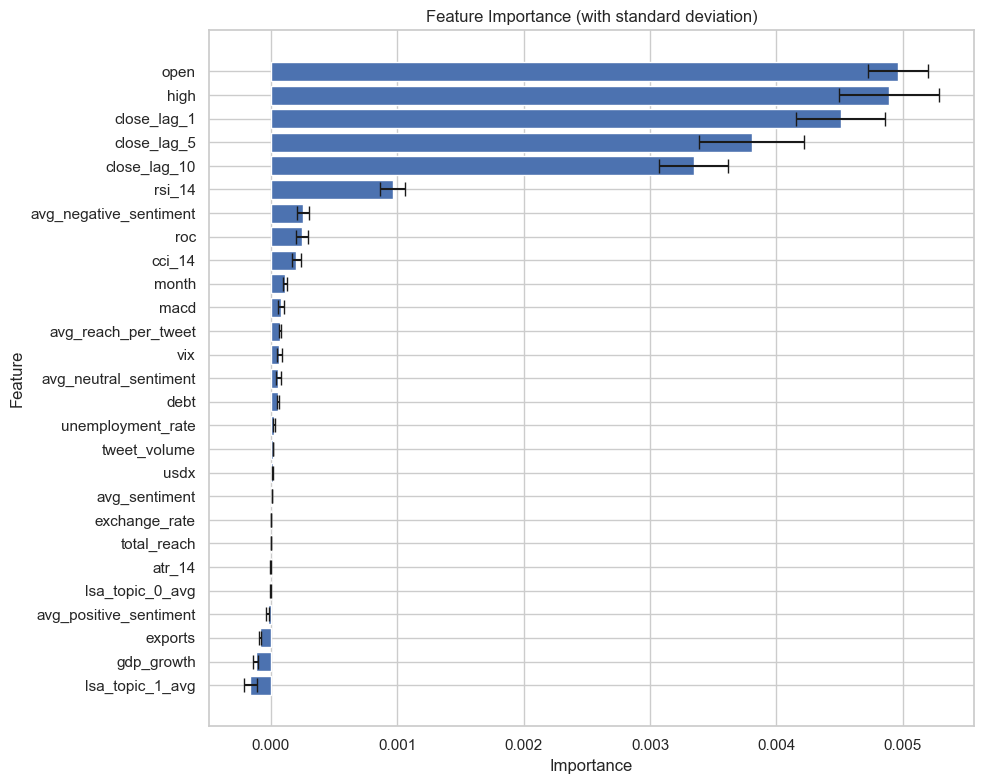

In [32]:
def custom_permutation_importance_3d(model, X_val, y_val, features, n_repeats=10, n_jobs=None):
    def single_col_score(X, col):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, :, col])
        return mean_squared_error(y_val, model.predict(X_permuted))

    baseline_score = mean_squared_error(y_val, model.predict(X_val))
    
    scores = Parallel(n_jobs=n_jobs)(
        delayed(single_col_score)(X_val, col)
        for _ in range(n_repeats)
        for col in range(X_val.shape[2])
    )

    scores = np.array(scores).reshape(n_repeats, -1)
    importances_mean = scores.mean(axis=0) - baseline_score
    importances_std = scores.std(axis=0)

    return importances_mean, importances_std
    
importances_mean, importances_std = custom_permutation_importance_3d(model, X_val, y_val, features, n_repeats=10)

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances_mean,
    'Std': importances_std
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'],
        xerr=feature_importance_df['Std'], capsize=5)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (with standard deviation)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

___
# Profitability and Risk

In [16]:
import numpy as np
import pandas as pd

def calculate_profitability_metrics(y_true, y_pred, dates, initial_investment=10000, risk_free_rate=0.02):
    df = pd.DataFrame({
        'date': dates,
        'actual': y_true,
        'predicted': y_pred
    })
    df['actual_return'] = df['actual'].pct_change()
    df['strategy_return'] = np.where(df['predicted'].shift() > df['actual'].shift(), df['actual_return'], -df['actual_return'])
    
    # 1. Return on Investment (ROI)
    total_return = (1 + df['strategy_return']).prod() - 1
    roi = (total_return / initial_investment) * 100
    
    # 2. Sharpe Ratio
    excess_returns = df['strategy_return'] - risk_free_rate / 252  # Assuming 252 trading days per year
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    # 3. Profit Factor
    winning_trades = df[df['strategy_return'] > 0]['strategy_return'].sum()
    losing_trades = abs(df[df['strategy_return'] < 0]['strategy_return'].sum())
    profit_factor = winning_trades / losing_trades if losing_trades != 0 else np.inf
    
    # 4. Maximum Drawdown
    cumulative_returns = (1 + df['strategy_return']).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak) - 1
    max_drawdown = drawdown.min() * 100
    
    # 5. Win Rate
    total_trades = len(df) - 1  # Excluding the first row as it doesn't have a return
    winning_trades_count = (df['strategy_return'] > 0).sum()
    win_rate = (winning_trades_count / total_trades) * 100
    
    return {
        'ROI (%)': roi,
        'Sharpe Ratio': sharpe_ratio,
        'Profit Factor': profit_factor,
        'Maximum Drawdown (%)': max_drawdown,
        'Win Rate (%)': win_rate
    }

metrics = calculate_profitability_metrics(y_val_inv, y_pred_inv, val_data.index[sequence_length:])
for i in metrics.items():
    print(i[0], f"{i[1]:.4f}")

ROI (%) -0.0014
Sharpe Ratio -0.6940
Profit Factor 0.9021
Maximum Drawdown (%) -27.9018
Win Rate (%) 45.5399


____
# Comparing dropped features vs with features

In [17]:
from models import att_lstm_cnn
initial_features = features

# Filter out features with negative importance scores
filtered_features = feature_importance_df[feature_importance_df['Importance'] >= 0]['Feature'].tolist()

# Fit a new scaler on the filtered features
filtered_features_with_target = filtered_features + ['close']
scaler_filtered = MinMaxScaler()
train_data_scaled_filtered = pd.DataFrame(scaler_filtered.fit_transform(train_data[filtered_features_with_target]),
                                          columns=filtered_features_with_target,
                                          index=train_data.index)

val_data_scaled_filtered = pd.DataFrame(scaler_filtered.transform(val_data[filtered_features_with_target]),
                                        columns=filtered_features_with_target,
                                        index=val_data.index)

# Prepare sequences with filtered features
X_train_filtered, y_train_filtered = prepare_sequences(train_data_scaled_filtered, filtered_features, target_column, sequence_length)
X_val_filtered, y_val_filtered = prepare_sequences(val_data_scaled_filtered, filtered_features, target_column, sequence_length)

# Re-create and train the model with filtered features
model_filtered = att_lstm_cnn((sequence_length, len(filtered_features)))
history_filtered = model_filtered.fit(
    X_train_filtered, y_train_filtered,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_filtered, y_val_filtered),
    callbacks=[early_stopping],
    verbose=1
)

# Predict and evaluate the model with filtered features
y_pred_filtered = model_filtered.predict(X_val_filtered)

# Inverse transform only the 'close' column for the evaluation
y_val_inv_filtered = scaler_filtered.inverse_transform(np.column_stack((np.zeros((len(y_val_filtered), len(filtered_features))), y_val_filtered)))[:, -1]
y_pred_inv_filtered = scaler_filtered.inverse_transform(np.column_stack((np.zeros((len(y_pred_filtered), len(filtered_features))), y_pred_filtered)))[:, -1]

mae_filtered, rmse_filtered, r2_filtered = evaluate_model(y_val_inv_filtered, y_pred_inv_filtered)
print(f"Filtered Features - MAE: {mae_filtered:.4f}, RMSE: {rmse_filtered:.4f}, R2: {r2_filtered:.4f}")

# Compare performance metrics
if mae_filtered < mae and rmse_filtered < rmse:
    print("Dropping features improved model performance.")
else:
    print("Dropping features did not improve model performance; reconsider feature selection.")


NameError: name 'lstmcnn' is not defined

____
# TSCV

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:(i+seq_length)].values)
        y.append(data['close'].iloc[i+seq_length])
    return np.array(X), np.array(y)

def create_lstm_cnn_model(input_shape):
    l2_val = 1e-3
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='relu', return_sequences=False, kernel_regularizer=l2(l2_val)),
        Dropout(0.4),
        Dense(1, kernel_regularizer=l2(l2_val))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='huber', metrics=['mae'])
    return model

def train_evaluate_model(data, features, target_column, sequence_length, n_splits=5, batch_size=32, epochs=100):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    histories = []
    predictions = []
    true_values = []
    
    for train_index, val_index in tscv.split(data):
        train_data = data.iloc[train_index]
        val_data = data.iloc[val_index]
        
        scaler = MinMaxScaler()
        train_scaled = pd.DataFrame(
            scaler.fit_transform(train_data[features + [target_column]]),
            columns=features + [target_column],
            index=train_data.index
        )
        val_scaled = pd.DataFrame(
            scaler.transform(val_data[features + [target_column]]),
            columns=features + [target_column],
            index=val_data.index
        )
        
        X_train, y_train = create_sequences(train_scaled, sequence_length)
        X_val, y_val = create_sequences(val_scaled, sequence_length)
        
        model = create_lstm_cnn_model((sequence_length, len(features)))
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=1
        )
        
        histories.append(history)
        
        val_pred = model.predict(X_val).flatten()
        
        val_pred_inv = scaler.inverse_transform(np.column_stack((np.zeros((len(val_pred), len(features))), val_pred)))[:, -1]
        y_val_inv = scaler.inverse_transform(np.column_stack((np.zeros((len(y_val), len(features))), y_val)))[:, -1]
        
        predictions.extend(val_pred_inv)
        true_values.extend(y_val_inv)
    
    return histories, np.array(predictions), np.array(true_values)

sequence_length = 30  
target_column = 'close'

histories, y_pred, y_true = train_evaluate_model(
    combined_data, 
    features, 
    target_column, 
    sequence_length
)

mae, rmse, r2 = evaluate_model(y_true, y_pred)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

plot_results(y_true, y_pred, 'LSTM-CNN Model with TSCV: Actual vs Predicted Stock Prices', histories[-1])

In [ ]:
import winsound
winsound.Beep(400,1000)